In [1]:
from IPython.display import Markdown, display

with open('ORB.md', 'r', encoding='utf-8') as f:
    markdown_content = f.read()
display(Markdown(markdown_content))


Детектор особых точек ORB (Oriented FAST and Rotated BRIEF) — алгоритм, основанный на комбинации детектора FAST и дескриптора BRIEF.

Далее представлены основные этапы этого метода:

---

### 1. **Обнаружение угловых точек с помощью FAST**
   - **FAST (Features from Accelerated Segment Test)**:
     - Для каждой точки анализируются 16 пикселей из окружности.
     - Точка считается подозрительной на особую, если определённое количество соседей (обычно 9-12) значительно ярче или темнее её. ${I_p} > {I_c} + t$ или ${I_p} < {I_c} - t$, где $t\,-$ пороговая величина <!---Возможно стоит написать про упрощение в виде рассмотрения определенных номеров пикселей -->
     - Для обнаруженных точек вычисляется мера Харриса, кандидаты с низким значением меры Харриса отбрасываются. По умолчанию в ORB максимальное количество точек - 500
     - Для инвариантности к масштабированию применяется алгоритм на пирамиде Гаусса.  <!--- Разный масштаб изображения -->
     - Вычисляется угол ориентации $\theta  = atan2 \left( {{m_{01}},{m_{10}}} \right) ; \, {m_{pq}} = \sum\limits_{x,y} {{x^p}{y^q}I\left( {x,y} \right)} $

![FAST_illustration](FAST_illustration.png)

[//]: # (Source: https://habr.com/ru/articles/414459/)

---



### 2. **Построение дескриптора BRIEF**
   - **BRIEF (Binary Robust Independent Elementary Features)**:
     - Дескриптор формируется как бинарный вектор размерности 256, сравнивающий яркости случайных пар пикселей в окрестности 31x31 пикселя вокруг ключевой точки:
   
     $$
     \tau \left( {p;x,y} \right) = \left\{ {\begin{array}{*{20}{c}} {1:{p_x} < {p_y}}\\ {0:{p_x} \ge {p_y}} \end{array}} \right.
     $$
     где p - интенсивность области 5x5

     - Пары пикселей поворачиваются на угол ориентации θ для достижения инвариантности по вращению
     - Для повышения качества ORB **оптимизирует выбор бинарных тестов**
   

[//]: # (Возможно, стоит формально записать вектор дескриптора из презентации / оригинальной статьи: https://sci-hub.ru/10.1109/ICCV.2011.6126544) 
     


---

### Преимущества ORB
- **Высокая скорость**: Быстрее SIFT и SURF за счёт бинарных операций.
- **Инвариантность**: К повороту, масштабу (с пирамидой) и небольшим изменениям освещения.
- **Низкие требования к памяти**: Бинарные дескрипторы компактны.
- **Открытая реализация**: В отличие от патентованных SURF/SIFT.

---

### Недостатки
- Менее устойчив к сильным изменениям освещения или перспективным искажениям.
- Точность может уступать SIFT в сложных сценах.

---

### Применение
- Сопоставление изображений (например, в SLAM-системах).
- Распознавание объектов.
- Дополненная реальность (AR).
- Редактирование фото (панорамная склейка).

ORB стал популярным выбором для задач, где важны скорость и ресурсоэффективность, например, в мобильных приложениях или робототехнике.

[//]: # (Sources: презентация + habr + deepseek)

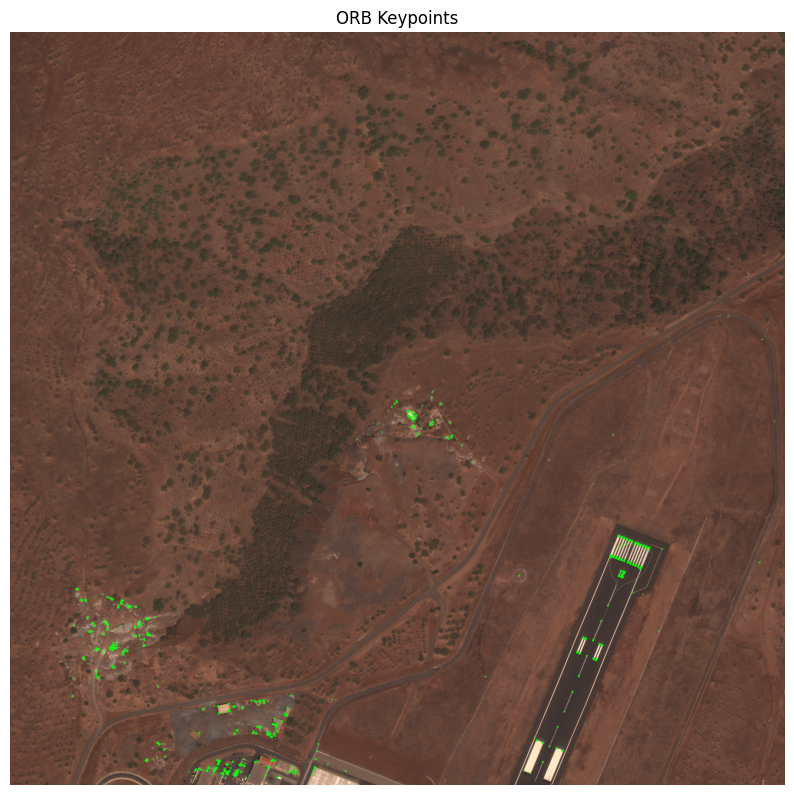

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

# === Шаг 1: Загрузка изображения ===
image_path = "images/train_images/8.tif"
image = cv2.imread(image_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# === Шаг 2: Детектирование ключевых точек с ORB ===
orb = cv2.ORB_create(nfeatures=2000)
keypoints = orb.detect(gray, None)

# === Визуализация точек интереса ===
img_with_kp = cv2.drawKeypoints(image, keypoints, None, color=(0, 255, 0), flags=0)
plt.figure(figsize=(10, 10))
plt.title("ORB Keypoints")
plt.imshow(cv2.cvtColor(img_with_kp, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [3]:
with open('DBSCAN.md', 'r', encoding='utf-8') as f:
    markdown_content = f.read()
display(Markdown(markdown_content))

**Алгоритм DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) — метод кластеризации, основанный на плотности данных. 

Вот его основные компоненты и шаги:

---

### **Гиперпараметры**
1. **ε-окрестность (epsilon)**:  
    Радиус вокруг точки, в котором ищутся соседи
2. **minPts**:  
   Минимальное количество точек в ε-окрестности, чтобы точка считалась **ядром**

---

### **Типы точек**
1. **Ядерные точки** (core points):  
    Точки в кластере, имеющие в своей ε-окрестности minPts соседей или более. Это означает, что точки лежат в области высокой плотности данных

2. **Пограничные точки** (border points):  
    Точки в кластере, которые имеют меньше, чем minPts соседей в своей ε-окрестности, но лежат в ε-окрестности других базовых точек. Это означает, что точки лежат на границе кластеров

3. **Шумовые точки** (noise points):  
    Выбросы, которые не принадлежат ни к одному кластеру, то есть точки расположены в области низкой плотности данных

---

### **Шаги алгоритма**
1. **Выбор начальной точки**:  
   Берётся произвольная необработанная точка. Если она не является ядром, помечается как шум.
2. **Поиск всех достижимых точек**:  
   Если точка — ядро, формируется кластер. Все точки в её ε-окрестности добавляются в кластер.
3. **Расширение кластера**:  
   Для каждой новой точки в кластере проверяется, является ли она ядром. Если да, её ε-окрестность также добавляется в кластер.
4. **Повторение**:  
   Процесс повторяется для всех необработанных точек. Невошедшие в кластеры точки помечаются как шум.

---

### **Преимущества**
- Не требует задания числа кластеров заранее.
- Обнаруживает кластеры произвольной формы (в отличие от k-means).
- Устойчив к шуму и выбросам.

---

### **Недостатки**
- Чувствителен к выбору *ε* и *minPts*.
- Плохо работает с кластерами разной плотности.
- Сложность вычислений: в худшем случае *O(n²)*, но оптимизации (например, индексация) снижают до *O(n log n)*.

---
### **Сравнение с другими алгоритмами**

![DBSCAN_comparison](DBSCAN_comparison.png)

[//]: # (Source: https://scikit-learn.org/stable/modules/clustering.html)

---

**Итог**: DBSCAN эффективен для данных с неравномерной плотностью и наличием шума, но требует тщательного подбора параметров.


[//]: # (оригинальная статья: https://www.dbs.ifi.lmu.de/Publikationen/Papers/KDD-96.final.frame.pdf)

[//]: # (хабр 1: https://habr.com/ru/articles/322034/)

[//]: # (хабр 2: https://habr.com/ru/articles/798331/#dbscan)

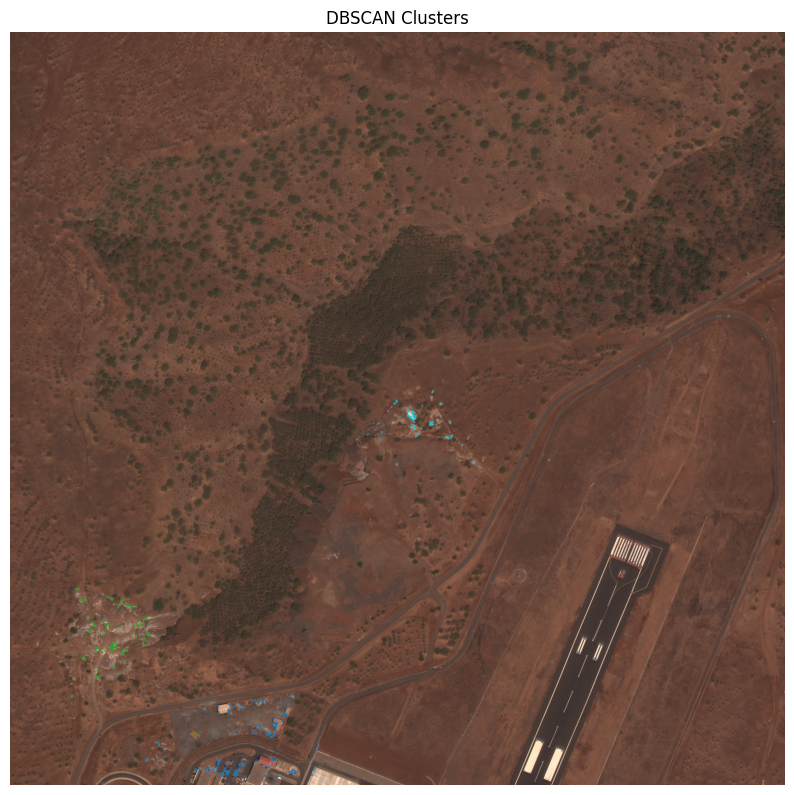

In [4]:
# === Шаг 3: Кластеризация DBSCAN ===
points = np.array([kp.pt for kp in keypoints])
scaled_points = StandardScaler().fit_transform(points)

db = DBSCAN(eps=0.2, min_samples=10).fit(scaled_points)
labels = db.labels_

# === Шаг 4: Рисуем кластеры на изображении ===
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
colors = plt.get_cmap('tab10', n_clusters)

cluster_img = image.copy()

for idx, (point, label) in enumerate(zip(points, labels)):
    if label == -1:
        color = (100, 100, 100)  # "шум"
    else:
        c = tuple(int(x * 255) for x in colors(label)[:3])
        color = c[::-1]  # BGR
    cv2.circle(cluster_img, (int(point[0]), int(point[1])), 3, color, -1)

plt.figure(figsize=(10, 10))
plt.title("DBSCAN Clusters")
plt.imshow(cv2.cvtColor(cluster_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

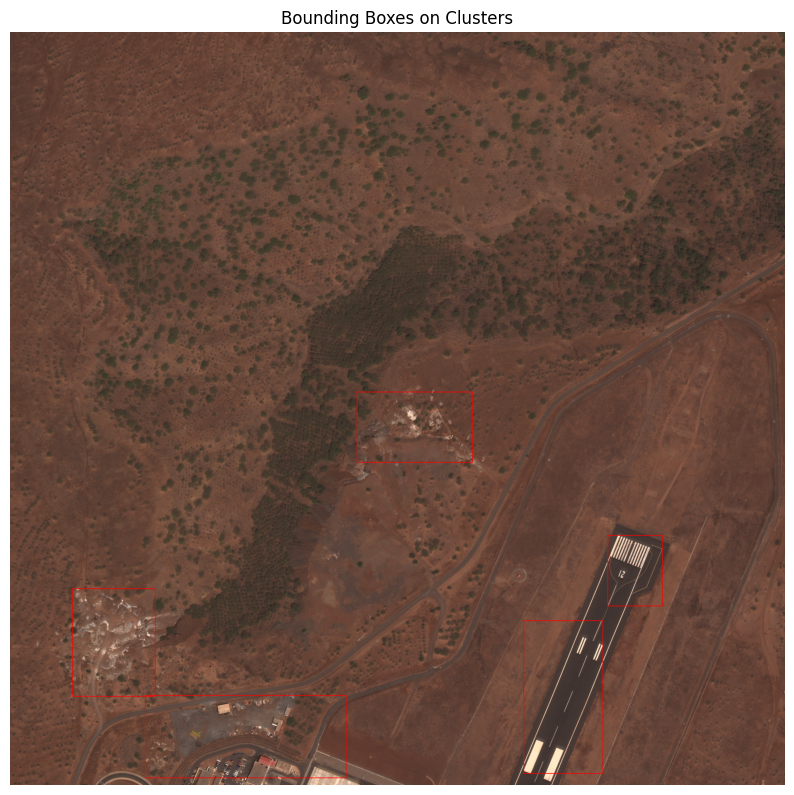

In [5]:
# === Шаг 5 и 6: Рисуем прямоугольники вокруг кластеров ===
final_img = image.copy()
unique_labels = set(labels)
for label in unique_labels:
    if label == -1:
        continue  # пропускаем шум

    cluster_points = points[labels == label]
    x, y, w, h = cv2.boundingRect(cluster_points.astype(np.int32))
    cv2.rectangle(final_img, (x, y), (x + w, y + h), (0, 0, 255), 2)

plt.figure(figsize=(10, 10))
plt.title("Bounding Boxes on Clusters")
plt.imshow(cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

# Бинарная классификация


## Создание модели SVM

In [6]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Параметры
DATA_DIR = 'images/crops/bin'
TARGET_CLASS = 'Small Car'  # Класс, который будет считаться положительным
IMAGE_SIZE = (64, 64)       # Приводим все изображения к одному размеру
TEST_SIZE = 0.2             # Доля тестовой выборки
RANDOM_STATE = 42           # Для воспроизводимости

# Функция загрузки изображений и меток
def load_data(data_dir, target_class):
    X = []
    y = []

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue  # <-- если не папка, сразу перескакиваем

        # Метку присваиваем только после проверки
        if class_name == target_class:
            label = 1
        else: 
            label = 0
    
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            features = hog(img,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           block_norm='L2-Hys',
                           feature_vector=True)
            X.append(features)
            y.append(label)

    
    return np.array(X), np.array(y)

# Загрузка данных
X, y = load_data(DATA_DIR, TARGET_CLASS)

print(f"Данных загружено: {len(X)} изображений")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)
from sklearn.svm import SVC
# Обучение модели
model = SVC(kernel='linear', probability=True, random_state=RANDOM_STATE)  # Можно менять kernel
model.fit(X_train, y_train)

# Оценка на тесте
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


Данных загружено: 3694 изображений
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       227
           1       1.00      0.98      0.99       512

    accuracy                           0.99       739
   macro avg       0.98      0.99      0.99       739
weighted avg       0.99      0.99      0.99       739



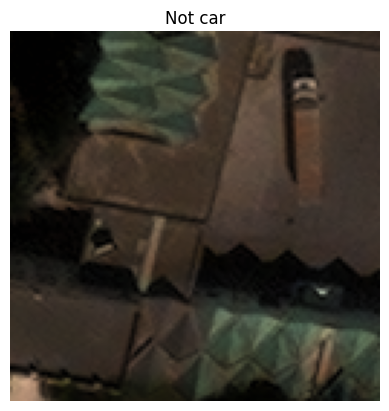

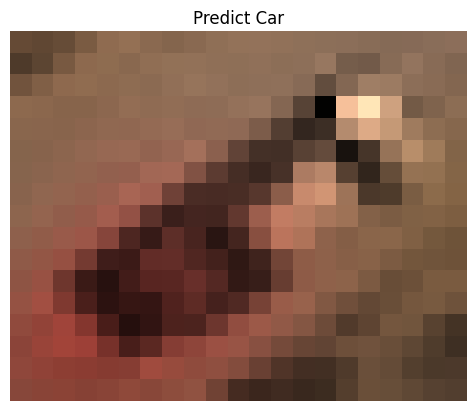

In [7]:
img = cv2.imread('images/crops/bin/test_truck.png', cv2.IMREAD_GRAYSCALE)
norm_image=cv2.imread('images/crops/bin/test_truck.png')
img = cv2.resize(img, IMAGE_SIZE)
features = hog(img,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               feature_vector=True)
predict = model.predict(features.reshape(1, -1))
plt.imshow(cv2.cvtColor(norm_image, cv2.COLOR_BGR2RGB))
plt.title('Predict ' + 'Car' if predict[0] == 1 else 'Not car')
plt.axis('off')
plt.show()

img = cv2.imread('images/crops/bin/test_car_2.png', cv2.IMREAD_GRAYSCALE)
norm_image=cv2.imread('images/crops/bin/test_car_2.png')
img = cv2.resize(img, IMAGE_SIZE)
features = hog(img,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               feature_vector=True)
predict = model.predict(features.reshape(1, -1))
plt.imshow(cv2.cvtColor(norm_image, cv2.COLOR_BGR2RGB))
plt.title('Predict '+ 'Car' if predict[0] == 1 else 'Not car')
plt.axis('off')
plt.show()

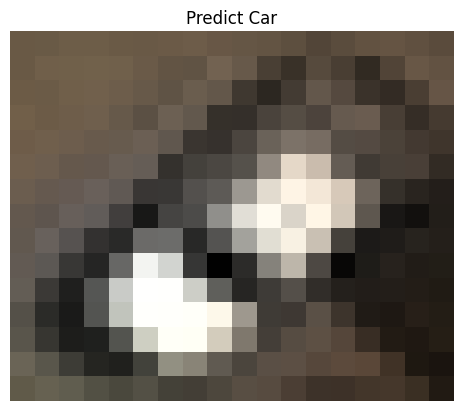

In [8]:
img = cv2.imread('images/crops/bin/test_car.png', cv2.IMREAD_GRAYSCALE)
norm_image=cv2.imread('images/crops/bin/test_car.png')
img = cv2.resize(img, IMAGE_SIZE)
features = hog(img,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               feature_vector=True)
predict = model.predict(features.reshape(1, -1))
plt.imshow(cv2.cvtColor(norm_image, cv2.COLOR_BGR2RGB))
plt.title('Predict '+ 'Car' if predict[0] == 1 else 'Not car')
plt.axis('off')
plt.show()

## Реализация идеи с ORB+DBSCAN+SVM

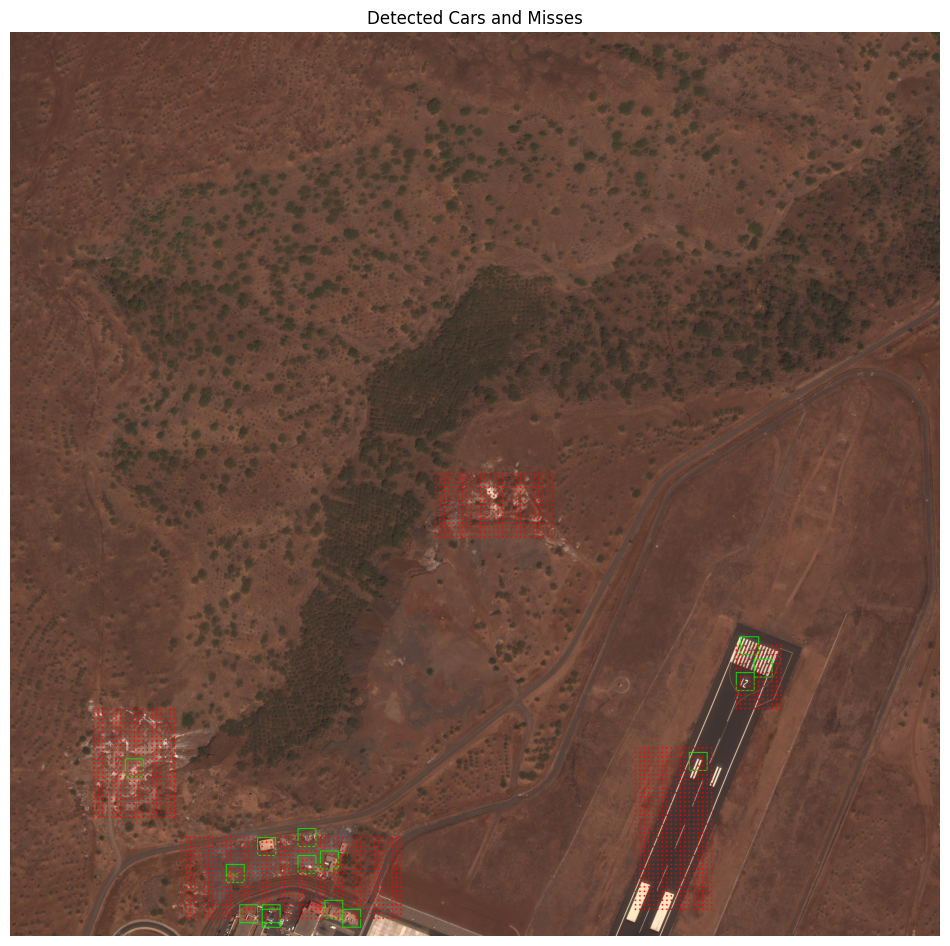

In [10]:
# === Шаг 7: Проход скользящим окном + классификация с пометкой "не найдены" ===

window_size = IMAGE_SIZE  # (64, 64)
stride = 16  # шаг окна

detected_img = image.copy()

for label in unique_labels:
    if label == -1:
        continue  # пропускаем шум

    cluster_points = points[labels == label]
    x, y, w, h = cv2.boundingRect(cluster_points.astype(np.int32))

    # Проходим по окнам в пределах кластера
    for y_top in range(y, y + h - window_size[1] + 1, stride):
        for x_left in range(x, x + w - window_size[0] + 1, stride):
            patch = gray[y_top:y_top + window_size[1], x_left:x_left + window_size[0]]
            if patch.shape != window_size:
                continue  # Пропускаем, если кусок меньше окна (на границах)

            # Извлекаем признаки HOG
            features = hog(patch,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           block_norm='L2-Hys',
                           feature_vector=True)
            features = features.reshape(1, -1)

            # Предсказание
            proba = model.predict_proba(features)[0, 1]  # вероятность класса "машина"

            if proba > 0.8:
                # Найден автомобиль
                cv2.rectangle(detected_img, 
                              (x_left, y_top), 
                              (x_left + window_size[0], y_top + window_size[1]), 
                              (0, 255, 0), 2)
            else:
                # Машина не найдена — ставим красную точку в центр окна
                center_x = x_left + window_size[0] // 2
                center_y = y_top + window_size[1] // 2
                cv2.circle(detected_img, (center_x, center_y), 3, (0, 0, 255), -1)

# Визуализация результата
plt.figure(figsize=(12, 12))
plt.title("Detected Cars and Misses")
plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



In [ ]:
# === Шаг 7: Проход скользящим окном + классификация с пометкой "не найдены" ===

window_size = IMAGE_SIZE  # (64, 64)
stride = 16  # шаг окна

detected_img = image.copy()

for label in unique_labels:
    if label == -1:
        continue  # пропускаем шум

    cluster_points = points[labels == label]
    x, y, w, h = cv2.boundingRect(cluster_points.astype(np.int32))

    # Проходим по окнам в пределах кластера
    for y_top in range(y, y + h - window_size[1] + 1, stride):
        for x_left in range(x, x + w - window_size[0] + 1, stride):
            patch = gray[y_top:y_top + window_size[1], x_left:x_left + window_size[0]]
            if patch.shape != window_size:
                continue  # Пропускаем, если кусок меньше окна (на границах)

            # Извлекаем признаки HOG
            features = hog(patch,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           block_norm='L2-Hys',
                           feature_vector=True)
            features = features.reshape(1, -1)

            # Предсказание
            proba = model.predict_proba(features)[0, 1]  # вероятность класса "машина"

            if proba > 0.8:
                # Найден автомобиль
                cv2.rectangle(detected_img, 
                              (x_left, y_top), 
                              (x_left + window_size[0], y_top + window_size[1]), 
                              (0, 255, 0), 2)
            else:
                # Машина не найдена — ставим красную точку в центр окна
                center_x = x_left + window_size[0] // 2
                center_y = y_top + window_size[1] // 2
                cv2.circle(detected_img, (center_x, center_y), 3, (0, 0, 255), -1)

# Визуализация результата
plt.figure(figsize=(12, 12))
plt.title("Detected Cars and Misses")
plt.imshow(cv2.cvtColor(detected_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()



# Мультиклассовая классификация

In [2]:
import os
import cv2
import numpy as np
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report

# Параметры
DATA_DIR = 'images/crops/mult'
CLASSES = ['Aircraft Hangar', 'Barge', 'Excavator', 'Ferry', 'Small Aircraft', 'Small Car', 'Tower', 'Tugboat']
IMAGE_SIZE = (64, 64)
TEST_SIZE = 0.2
RANDOM_STATE = 42

# Функция загрузки изображений и меток
def load_data(data_dir, class_list):
    X = []
    y = []
    class_to_idx = {class_name: idx+1 for idx, class_name in enumerate(class_list)}

    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        if class_name  in class_to_idx:
            label = class_to_idx[class_name]
            
        else:
            label = 0
            

        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, IMAGE_SIZE)
            features = hog(img,
                           pixels_per_cell=(8, 8),
                           cells_per_block=(2, 2),
                           block_norm='L2-Hys',
                           feature_vector=True)
            X.append(features)
            y.append(label)

    return np.array(X), np.array(y)

# Загрузка данных
X, y = load_data(DATA_DIR, CLASSES)
print(f"Данных загружено: {len(X)} изображений")

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

# Обучение модели
model = LGBMClassifier(random_state=RANDOM_STATE)
model.fit(X_train, y_train)

# Оценка на тесте
y_pred = model.predict(X_test)
t_names = ['neg']+CLASSES
print(classification_report(y_test, y_pred, target_names=t_names))

Данных загружено: 832 изображений
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 365619
[LightGBM] [Info] Number of data points in the train set: 665, number of used features: 1764
[LightGBM] [Info] Start training from score -1.967188
[LightGBM] [Info] Start training from score -2.456736
[LightGBM] [Info] Start training from score -2.786215
[LightGBM] [Info] Start training from score -1.845827
[LightGBM] [Info] Start training from score -2.195722
[LightGBM] [Info] Start training from score -1.874814
[LightGBM] [Info] Start training from score -1.935439
[LightGBM] [Info] Start training from score -2.888869
[LightGBM] [Info] Start training from score -2.405442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits 

C:\Users\ufaba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\ufaba\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


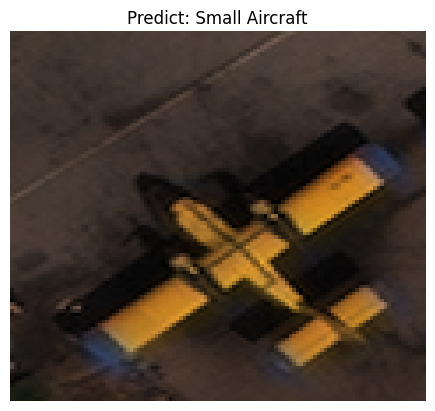

In [21]:
import matplotlib.pyplot as plt
img = cv2.imread('images/crops/mult/test_small_aircraft.png', cv2.IMREAD_GRAYSCALE)
norm_image=cv2.imread('images/crops/mult/test_small_aircraft.png')
img = cv2.resize(img, IMAGE_SIZE)
features = hog(img,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2),
               block_norm='L2-Hys',
               feature_vector=True)
predict = model.predict(features.reshape(1, -1))
plt.imshow(cv2.cvtColor(norm_image, cv2.COLOR_BGR2RGB))
plt.title('Predict: ' + str(CLASSES[predict[0]-1] if predict[0] != 0 else 'Not specified class'))
plt.axis('off')
plt.show()